# Generate 1D periodic data

In [1]:
import numpy as np

def gaussian(x, A, u, s):
    return A * np.exp(-((x - u)/s)**2/2)/(np.sqrt(2*np.pi)*s)

def wrap_gaussian(x, A, u, s):
    in_dis = np.abs(x-u)
    x_dis = np.minimum(in_dis, 1-in_dis)
    return gaussian(x_dis, A, 0, s)

def range_sampling(value_range, size):
    return np.random.random(size = size) * (value_range[1] - value_range[0]) + value_range[0]

In [2]:
data_num = 5000
n_max = 7
A_range = [0.00, 5.00]
u_range = [0.00, 1.00]
s_range = [0.001, 0.01]

In [3]:
x = np.linspace(0.0, 1.0, 257)[:-1]
As = range_sampling(A_range, (data_num, 1, n_max))
us = range_sampling(u_range, (data_num, 1, n_max))
ss = range_sampling(s_range, (data_num, 1, n_max))

In [4]:
data = np.sum(wrap_gaussian(x.reshape(1, -1, 1), As, us, ss), axis = -1)

# Visualize a data sample

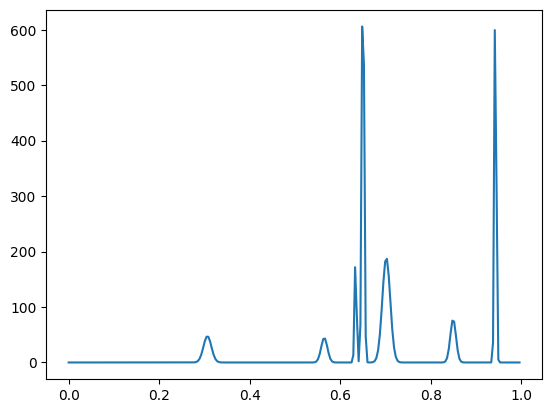

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x, data[0])
plt.show()

# 1D Periodic Autoencoder Class

In [7]:
import torch.nn as nn

In [8]:
def PConv1d(in_channels, out_channels, padding):
    return nn.Sequential(
                            nn.CircularPad1d(padding),
                            nn.Conv1d(in_channels, out_channels, 2*padding+1)
                        )

In [ ]:
class PAE(nn.Module):
    def __init__(self):
        super(PAE, self).__init__()
        self.content_encoder = nn.Sequential(
                                                PConv1d(1, 1, 1),   # 256
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                PConv1d(1, 2, 1),   # 128
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                PConv1d(2, 2, 1),   # 64
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                PConv1d(2, 4, 1),   # 32
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                PConv1d(4, 4, 1),   # 16
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                PConv1d(4, 8, 1),   # 8
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                PConv1d(8, 16, 1),  # 4
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                PConv1d(16, 32, 1), # 2
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                            )
        self.context_encoder = nn.Sequential(
                                                nn.Conv1d(1, 1, 1), # 256
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                nn.Conv1d(1, 1, 1), # 128
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                nn.Conv1d(1, 1, 1), # 64
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                nn.Conv1d(1, 1, 1), # 32
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                nn.Conv1d(1, 1, 1), # 16
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                nn.Conv1d(1, 1, 1), # 8
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                                nn.Conv1d(1, 1, 1), # 4
                                                nn.ReLU(),
                                                nn.MaxPool1d(2, 2),
                                            )
        self.decoder = nn.Sequential()